## Objectives

* Train a machine learning model to predict the severity of a traffic accident, should an accident occur.
* Produce a list of 'best features'
* Use generative AI to aid with the ordering of the steps and hyperparameters

Accident severity: where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay)

In [33]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# import machine learning libraries

# data splitting into train and test sets
from sklearn.model_selection import train_test_split

# feature scaling and encoding
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# column transformer
from sklearn.compose import ColumnTransformer

# ML algorithm
from sklearn.tree import DecisionTreeClassifier

# feature selection
from sklearn.feature_selection import SelectFromModel

# pipeline
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The machine learning model we will use is a **Classification** model because the target variable, severity, has four possible states.
The target is available, therefore the model is **Supervised**.

In [35]:
# load the cleaned data in to a dataframe
df = pd.read_csv('../data/cleaned_data/us_accidents_cleaned.csv')
df.head()

,severity,start_lat,start_lng,description,city,county,state,temperature(f),humidity(%),visibility(mi),...,precipitation(in),weather_condition,crossing,junction,traffic_signal,sunrise_sunset,year,month,day,time
0,2,37.530804,-122.297714,Accident on 39th Ave at Edison St.,San Mateo,San Mateo,CA,69.8,56.0,9.0,...,0.0,Clear,False,False,False,Day,2016,July,1,13:17:37
1,2,27.960699,-82.705109,Accident on Bayshore Blvd at FL-60 Gulf To Bay...,Clearwater,Pinellas,FL,84.0,82.0,9.0,...,0.0,Fair,True,False,True,Day,2019,June,26,08:17:21
2,2,37.701230,-121.834055,Stationary traffic on I-580 W from Airway Blvd...,Livermore,Alameda,CA,68.0,39.0,10.0,...,0.0,Fair,False,False,False,Day,2022,February,19,13:59:30
3,2,42.385570,-83.261400,At I-96 Local/Outer Dr/Exit 180 - Accident.,Detroit,Wayne,MI,67.5,85.0,10.0,...,0.0,Clear,False,True,False,Day,2018,August,20,07:36:17
4,2,38.347090,-112.659636,At I-15-BL/1400 St/Exit 112 - Accident.,Beaver,Beaver,UT,26.6,80.0,10.0,...,0.0,Mostly Cloudy,False,False,False,Day,2019,February,17,09:48:00


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   severity           4839 non-null   int64  
 1   start_lat          4839 non-null   float64
 2   start_lng          4839 non-null   float64
 3   description        4839 non-null   object 
 4   city               4839 non-null   object 
 5   county             4839 non-null   object 
 6   state              4839 non-null   object 
 7   temperature(f)     4839 non-null   float64
 8   humidity(%)        4839 non-null   float64
 9   visibility(mi)     4839 non-null   float64
 10  wind_direction     4839 non-null   object 
 11  wind_speed(mph)    4839 non-null   float64
 12  precipitation(in)  4839 non-null   float64
 13  weather_condition  4839 non-null   object 
 14  crossing           4839 non-null   bool   
 15  junction           4839 non-null   bool   
 16  traffic_signal     4839 

In [37]:
# convert categorical columns to category data type for use in machine learning
category_cols = ["description", "city", "county", "state", "wind_direction", "weather_condition", "sunrise_sunset", "month", "time"]
for cat in category_cols:
    df[cat] = df[cat].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   severity           4839 non-null   int64   
 1   start_lat          4839 non-null   float64 
 2   start_lng          4839 non-null   float64 
 3   description        4839 non-null   category
 4   city               4839 non-null   category
 5   county             4839 non-null   category
 6   state              4839 non-null   category
 7   temperature(f)     4839 non-null   float64 
 8   humidity(%)        4839 non-null   float64 
 9   visibility(mi)     4839 non-null   float64 
 10  wind_direction     4839 non-null   category
 11  wind_speed(mph)    4839 non-null   float64 
 12  precipitation(in)  4839 non-null   float64 
 13  weather_condition  4839 non-null   category
 14  crossing           4839 non-null   bool    
 15  junction           4839 non-null   bool    
 16  traffi

We will split the data into train and test sets, 80% of the data will be used for training with 20% for testing.

The data will be scaled after splitting into train and test because fitting the scaler on all data before splitting causes data leakage.
The test set would influence scaling parameters, making evaluation overly optimistic.

In [38]:
# split the data into training and testing sets
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['severity'],axis=1),
                                    df['severity'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (3871, 21) (3871,) 
* Test set: (968, 21) (968,)


## Decision Tree Classifier

We will now create a decision tree, where each question has a yes/no answer, much like a flow chart. As it gets deeper, you move from a general question to a very specific question. The questions asked must be yes or no answers to give useful insights into the data. Eventually leading to predict the severity of a traffic accident given the conditions. 

In [39]:
# create a preprocessing and modelling pipeline
# generative AI model suggested code to help with the ordering of steps

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["city", "county", "state", "wind_direction", 
                        "weather_condition", "sunrise_sunset", "month", "time"]
numeric_features = ["start_lat", "start_lng", "temperature(f)", "humidity(%)","visibility(mi)",
                    "wind_speed(mph)","precipitation(in)","year","day"]
boolean_features = ["crossing", "junction", "traffic_signal"]

# Add boolean directly to numeric features for ease of scaling
numeric_features += boolean_features

# Use OneHotEncoder with handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

pre_process = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# use random state = 42 for reproducibility
model = Pipeline(steps=[
    ('pre_process', pre_process),
    ('feat_selection', SelectFromModel(
        DecisionTreeClassifier(
            random_state=42,
            class_weight="balanced"
        )
    )),
    ('tree_clf', DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'county', 'state',
                                                   'wind_direction',
                                                   'weather_condition',
                                                   'sunrise_sunset', 'month',
                                                   'time']),
                                                 ('num', StandardScaler(),
                                                  ['start_lat', 'start_lng',
                                                   'temperature(f)',
                                                   'humidity(%)',
                                                   'visibility(mi)',
                                                   'wind_speed(mph)',
                                                   'precipitation(in)', 'year',
                                                   'day', 'crossing',
                                                   'junction',
                                                   'traffic_signal'])])),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                  random_state=42))),
                ('tree_clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

Now the model is fitted we need to:

- Make predictions
- Evaluate the model performance
- See which features were selected
- Save the pipeline for later
- Discuss hyperparameters
- Visualise the decision tree
- Test the model with new conditions


In [ ]:
# make predictions on the test set
# run the model to make predictions, check the training set as well
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [ ]:
# evaluate the model
# first, how did it do on the training set?
print("Accuracy score:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

Accuracy score: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00      3127
           3       1.00      1.00      1.00       620
           4       1.00      1.00      1.00       100

    accuracy                           1.00      3871
   macro avg       1.00      1.00      1.00      3871
weighted avg       1.00      1.00      1.00      3871


Confusion Matrix:
 [[  24    0    0    0]
 [   0 3127    0    0]
 [   0    0  620    0]
 [   0    0    0  100]]


The model was trained perfectly on the training set! The accuracy score is 1 and all scores were 100%, showing that the model learnt relationships from the data.

In [42]:
# now, how did it do on the test set?
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy score: 0.6993801652892562

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.84      0.80      0.82       772
           3       0.32      0.38      0.34       160
           4       0.03      0.03      0.03        30

    accuracy                           0.70       968
   macro avg       0.30      0.30      0.30       968
weighted avg       0.73      0.70      0.71       968


Confusion Matrix:
 [[  0   5   0   1]
 [  7 616 118  31]
 [  1  92  60   7]
 [  1  18  10   1]]


The model didn't do very well on the test data, only an accuracy score of 0.699.

Therefore we will try tuning the hyperparameters.

In [43]:
# hyperparameter tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'tree_clf__max_depth': [None, 5, 10, 20, 30],
    'tree_clf__min_samples_split': [2, 5, 10],
    'tree_clf__min_samples_leaf': [1, 2, 5, 10],
    'tree_clf__max_features': [None, 'sqrt', 'log2']
}

These parameters are chosen because they control the complexity, generalization, and feature usage of the Decision Tree. GridSearchCV explores them to find the best bias–variance trade-off.

* max_depth: how deep the tree can grow
* min_samples_split: minimum number of samples to split a node
* min_samples_leaf: minimum samples required in a leaf node
* max_features: number of features considered

In [ ]:
# create the GridSearchCV object

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, # use the defined param_grid above
    cv=5,
    scoring='f1_macro',   # using f1_macro for multi-class classification
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'county',
                                                                          'state',
                                                                          'wind_direction',
                                                                          'weather_condition',
                                                                          'sunrise_sunset',
                                                                          'month',
                                                                          'time']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['start_lat',
                                                                          'start_lng',
                                                                          'temperature(f)',
                                                                          'humidity(%)',
                                                                          'visibility(mi)',
                                                                          'wind_speed(mph)',
                                                                          'p...
                                        SelectFromModel(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                         random_state=42))),
                                       ('tree_clf',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'tree_clf__max_depth': [None, 5, 10, 20, 30],
                         'tree_clf__max_features': [None, 'sqrt', 'log2'],
                         'tree_clf__min_samples_leaf': [1, 2, 5, 10],
                         'tree_clf__min_samples_split': [2, 5, 10]},
             scoring='f1_macro', verbose=2)

In [ ]:
# get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_params)

{'tree_clf__max_depth': None, 'tree_clf__max_features': None, 'tree_clf__min_samples_leaf': 2, 'tree_clf__min_samples_split': 2}


In [ ]:
# evaluate the best model on the test set
y_pred = best_model.predict(X_test)

In [47]:
# after hyperparameter tuning, how did it do on the test set?
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy score: 0.6704545454545454

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.84      0.76      0.80       772
           3       0.27      0.36      0.31       160
           4       0.07      0.10      0.08        30

    accuracy                           0.67       968
   macro avg       0.29      0.31      0.30       968
weighted avg       0.72      0.67      0.69       968


Confusion Matrix:
 [[  0   3   2   1]
 [  8 588 144  32]
 [  1  93  58   8]
 [  1  16  10   3]]


Still not a good performance at 0.670 after hyperparameter tuning. This could be due to the imbalanced dataset with the majority of cases having a class 2 severity. 

We will extract the best features from this model, then if time allows, try an alternate model. 

Top most important features, not ordered:
['num__temperature(f)', 'num__start_lng', 'num__year', 'num__start_lat', 'num__humidity(%)', 'num__day', 'num__wind_speed(mph)', 'cat__time_08:35:05', 'cat__time_07:22:01', 'num__crossing']


Top most important features, in descending order:
['start', 'temperature(f)', 'year', 'humidity(%)', 'day', 'time', 'wind', 'crossing']


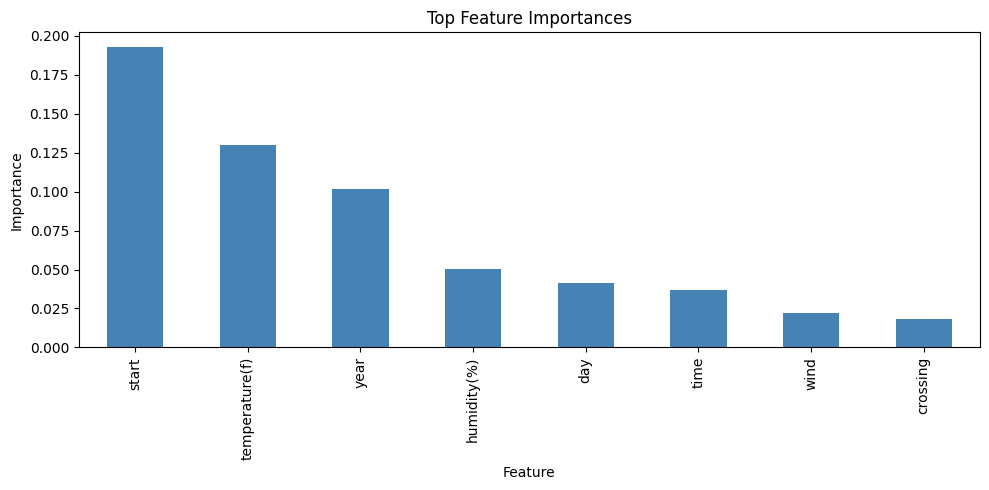

In [ ]:
# feature importance
# generative AI model and CI LMS heavily used here to help code feature importance extraction

# get the preprocessed feature names
preprocessor = model.named_steps['pre_process']
feature_names = preprocessor.get_feature_names_out()

# get mask of selected features
selector = model.named_steps['feat_selection']
selected_mask = selector.get_support()

selected_feature_names = feature_names[selected_mask]

# get feature importances from final tree
importances = model.named_steps['tree_clf'].feature_importances_

# create dataframe and select top 10
df_feature_importance = (
    pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    })
    .sort_values(by='Importance', ascending=False)
    .head(10)
)

# extract top 10 original features
# keeping the transformer prefixes for now
top_10_features_original_name = df_feature_importance['Feature'].head(10).tolist()

# print results
print("Top most important features, not ordered:")
print(top_10_features_original_name)
print("\n")

# remove transformer prefixes (cat__, num__)
df_feature_importance['Original_Feature'] = (
    df_feature_importance['Feature']
      .str.replace(r'^(cat|num)__', '', regex=True)
      .str.split('_')
      .str[0]
)

# aggregate to original feature level
df_aggregated = (
    df_feature_importance
        .groupby('Original_Feature', as_index=False)
        .Importance.sum()
        .sort_values(by='Importance', ascending=False)
)

# extract top 10 original features, without transformer prefixes
top_10_features = df_aggregated['Original_Feature'].head(10).tolist()

# print results
print("Top most important features, in descending order:")
print(top_10_features)

# plot aggregated feature importances
df_aggregated.plot(
    kind='bar',
    x='Original_Feature',
    y='Importance',
    legend=False,
    figsize=(10, 5),
    color='steelblue'
)

plt.title("Top Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

The model was trained on the most important features, they are, in descending order: Start location, temperature, year, humidity, day, time, wind and traffic crossing. 

In [ ]:
# save the model to a file
import joblib
joblib.dump(model, "traffic_classifier.pkl")

['traffic_classifier.pkl']

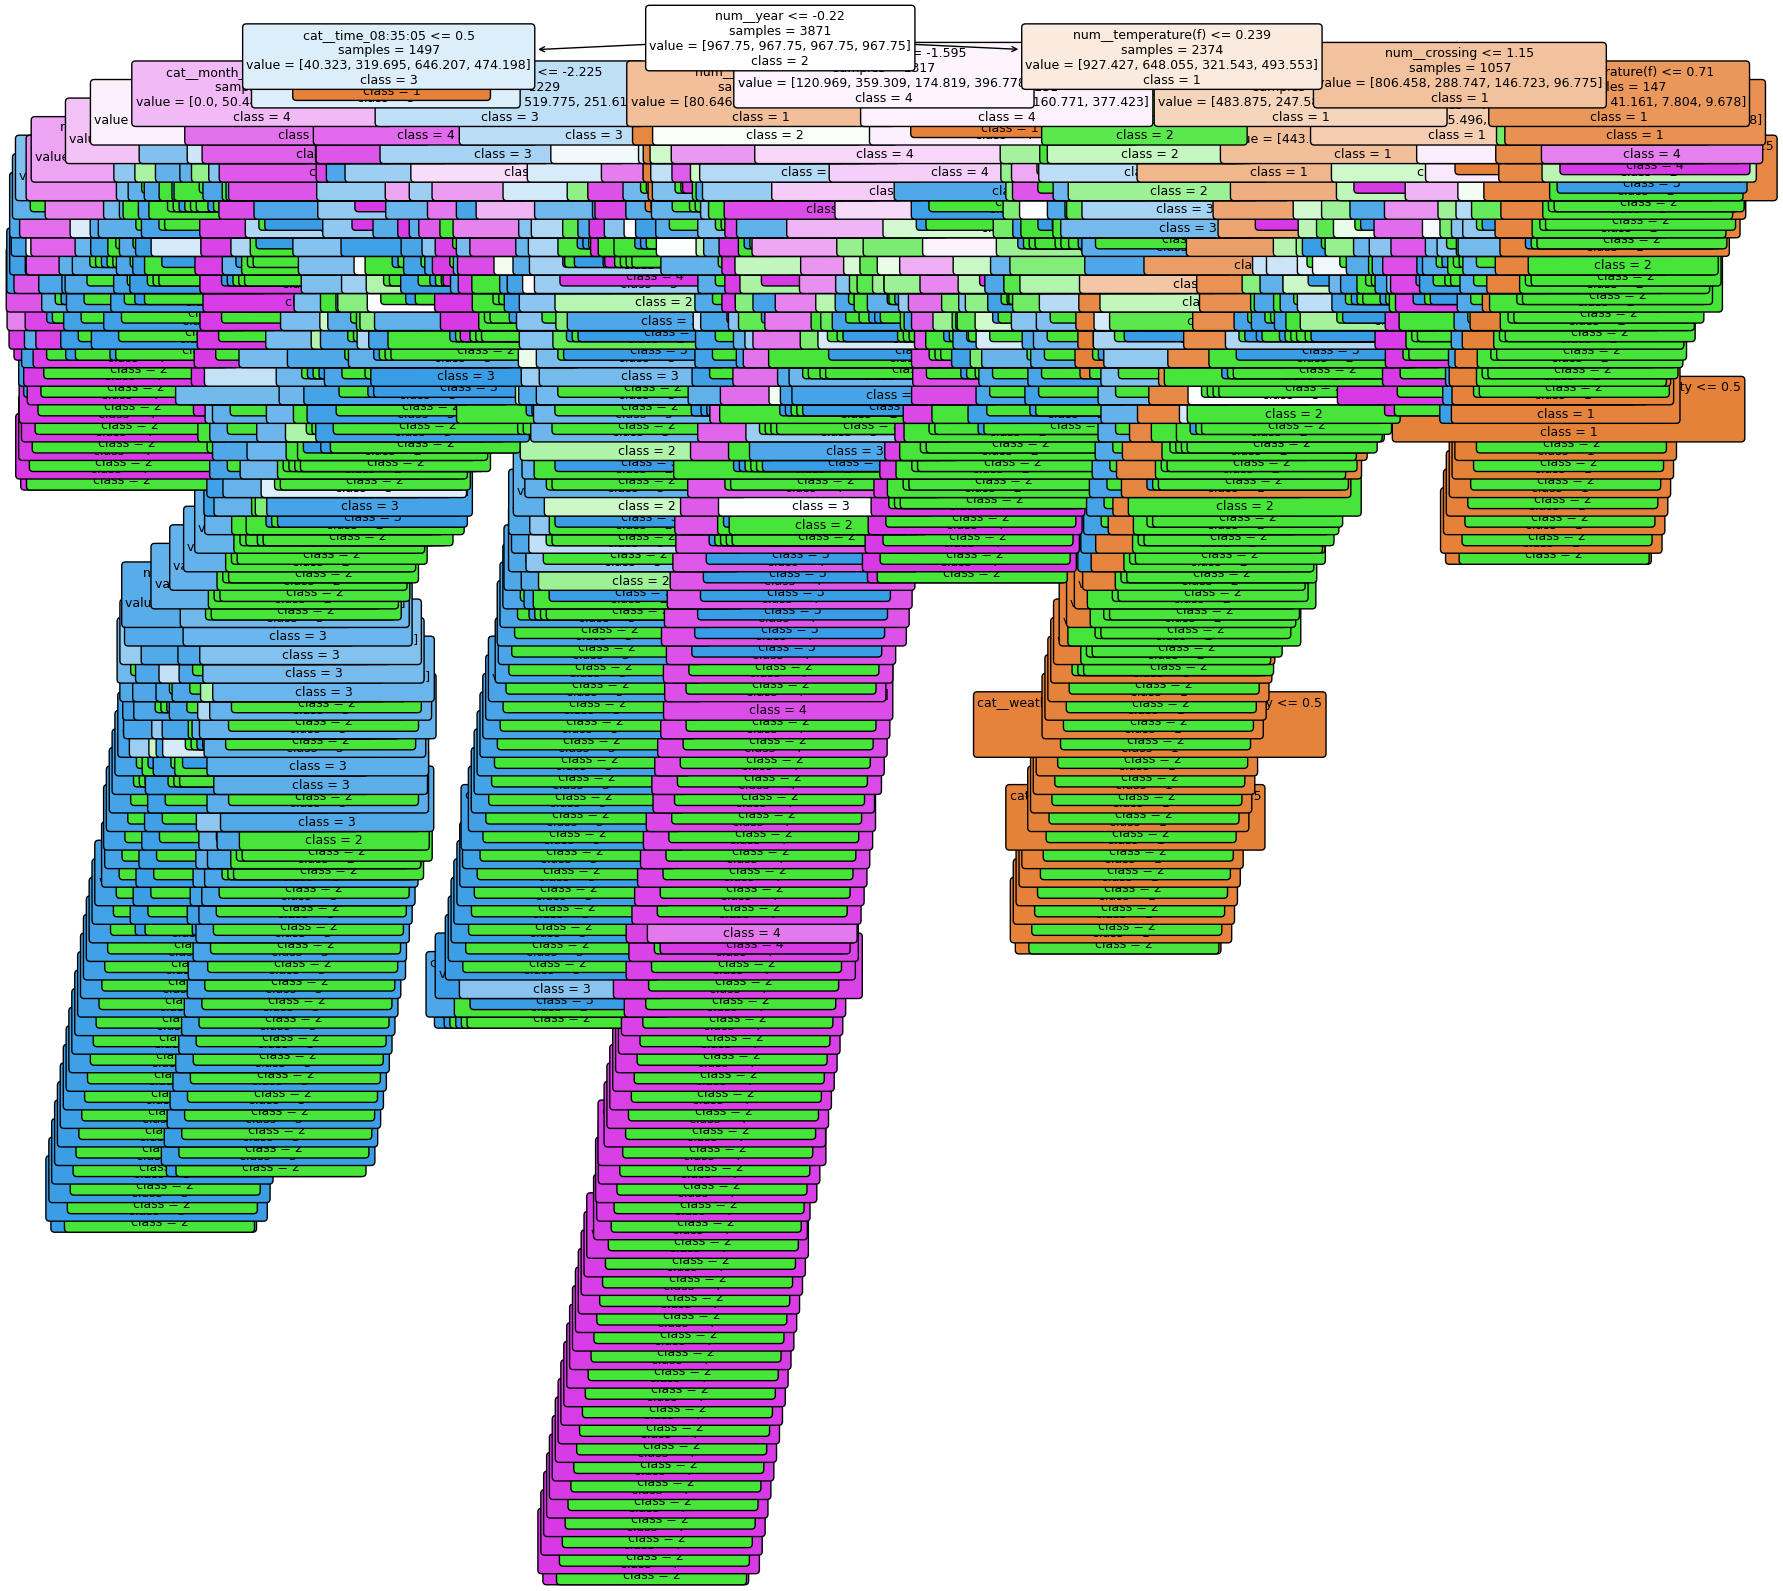

In [ ]:
# visualise the decision tree
from sklearn import tree

fig = plt.figure(figsize=(20,20))

tree.plot_tree(
    decision_tree = model['tree_clf'],
    feature_names = selected_features,
    class_names = model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=9,
    impurity=False
)

plt.show()

The decision tree figure above shows the decisions taken at each step of the model while it is learning which features are most important.

The variables are sometimes showing as negative within the decision tree, this is because the features were scaled in order to be suitable for input to the machine learning model.


Now we will test the model by passing in conditions in which we think a severity 1 or 2 accident might occur. 

In [86]:
df.head()

,severity,start_lat,start_lng,description,city,county,state,temperature(f),humidity(%),visibility(mi),...,precipitation(in),weather_condition,crossing,junction,traffic_signal,sunrise_sunset,year,month,day,time
0,2,37.530804,-122.297714,Accident on 39th Ave at Edison St.,San Mateo,San Mateo,CA,69.8,56.0,9.0,...,0.0,Clear,False,False,False,Day,2016,July,1,13:17:37
1,2,27.960699,-82.705109,Accident on Bayshore Blvd at FL-60 Gulf To Bay...,Clearwater,Pinellas,FL,84.0,82.0,9.0,...,0.0,Fair,True,False,True,Day,2019,June,26,08:17:21
2,2,37.701230,-121.834055,Stationary traffic on I-580 W from Airway Blvd...,Livermore,Alameda,CA,68.0,39.0,10.0,...,0.0,Fair,False,False,False,Day,2022,February,19,13:59:30
3,2,42.385570,-83.261400,At I-96 Local/Outer Dr/Exit 180 - Accident.,Detroit,Wayne,MI,67.5,85.0,10.0,...,0.0,Clear,False,True,False,Day,2018,August,20,07:36:17
4,2,38.347090,-112.659636,At I-15-BL/1400 St/Exit 112 - Accident.,Beaver,Beaver,UT,26.6,80.0,10.0,...,0.0,Mostly Cloudy,False,False,False,Day,2019,February,17,09:48:00


In [90]:
# test the model with a new sample
# no unknown categories in the new sample
# this is a situation that we expect to result in a severity of 1 or 2

new_cond_1 = pd.DataFrame([{
    "start_lat": 34.0522,
    "start_lng": -118.2437,
    "description": "Minor accident on Main St.",
    "city": "Los Angeles",
    "county": "Los Angeles",
    "state": "CA",
    "wind_direction": "NW",
    "weather_condition": "Clear",
    "sunrise_sunset": "Day",
    "temperature(f)": 75,
    "humidity(%)": 50,
    "visibility(mi)": 10,
    "wind_speed(mph)": 5,
    "precipitation(in)": 0,
    "year": 2023,
    "month": "June",
    "day": 15,
    "time": "14:30",
    "crossing": False,
    "junction": False,
    "traffic_signal": True
}])

In [88]:
prediction = model.predict(new_cond_1)
probability = model.predict_proba(new_cond_1)

print("Predicted class:", prediction[0])
print("Probability:", probability[0])

Predicted class: 2
Probability: [0. 1. 0. 0.]


As expected, the result is severity 2. 

Now we will test the model by passing in conditions in which we think a severity 3 or 4 accident might occur.

In [105]:
# test the model with a new sample
# no unknown categories in the new sample
# this is a situation that we expect to result in a severity of 3 or 4
new_cond_2 = pd.DataFrame([{
    "start_lat": 40.7128,
    "start_lng": -74.0060,
    "description": "Severe accident on 5th Ave.",
    "city": "New York",
    "county": "New York",
    "state": "NY",
    "wind_direction": "NE",
    "weather_condition": "Snow Heavy",
    "sunrise_sunset": "Night",
    "temperature(f)": 40,
    "humidity(%)": 90,
    "visibility(mi)": 1,
    "wind_speed(mph)": 65,
    "precipitation(in)": 1.0,
    "year": 2023,
    "month": "November",
    "day": 20,
    "time": "22:15",
    "crossing": True,
    "junction": True,
    "traffic_signal": False
}])

In [106]:
prediction = model.predict(new_cond_2)
probability = model.predict_proba(new_cond_2)

print("Predicted class:", prediction[0])
print("Probability:", probability[0])

Predicted class: 3
Probability: [0. 0. 1. 0.]


As expected the prediction is a severity of 3. 

### Conclusion:

A machine learning model has been created (a decision tree classifier) to discover which features are most important in predicting the severity of traffic accidents. 

The model could be improved with further adjusting hyperparameters. Perhaps a different type of Classifier might improve the classification scores. 

Given a set of conditions the model can predict the severity of a traffic accident (provided no unforeseen variables are used).